# House pricing regression using multilayer perceptron in pytorch

The goal of the project is to create a model for predicting housing prices based on boston housing prices dataset.
This is losely based on chapter 4.10 in dive to deep learning book.

We will also compare performance of our classifier to performance of SVR and linear regressor (provided by sklearn).

This is supposed to be a quick project so don't expect any fancy data preparation techniques or any tricks.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import torch.nn.functional as torch_fun
import torch
from torch import nn
from torch.utils import data
from torchsummary import summary
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Dataset preparation

First let's load and prepare dataset for training.

In [2]:
header = ["CRIM", "ZN", "INDUS", "CHAS", "NOX", 
           "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO",
           "B","LSTAT","PRICE"]

house_dataset = pd.read_csv("housing.csv", delimiter="\s+",
                            names=header)


In [3]:
house_dataset.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [4]:
house_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  PRICE    506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


Here are the following fields:

 - CRIM: Crime rate per capita crime rate by town.
 - ZN: proportion of residential land zoned for lots over 25,000 sq.ft.
 - INDUS: proportion of non-retail business acres per town
 - CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
 - NOX: nitric oxides concentration (parts per 10 million)
 - RM: average number of rooms per dwelling
 - AGE: proportion of owner-occupied units built prior to 1940
 - DIS: weighted distances to ﬁve Boston employment centers
 - RAD: index of accessibility to radial highways
 - TAX: full-value property-tax rate per 10,000 dollars
 - PTRATIO: pupil-teacher ratio by town
 - B: 1000(Bk−0.63)2 where Bk is the proportion of blacks by town 
 - LSTAT: % of lower status of the population
 - PRICE: Median value of owner-occupied homes in 1000s of dollars
 
 We are trying to predict price based other parameters.

In [5]:
house_dataset.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


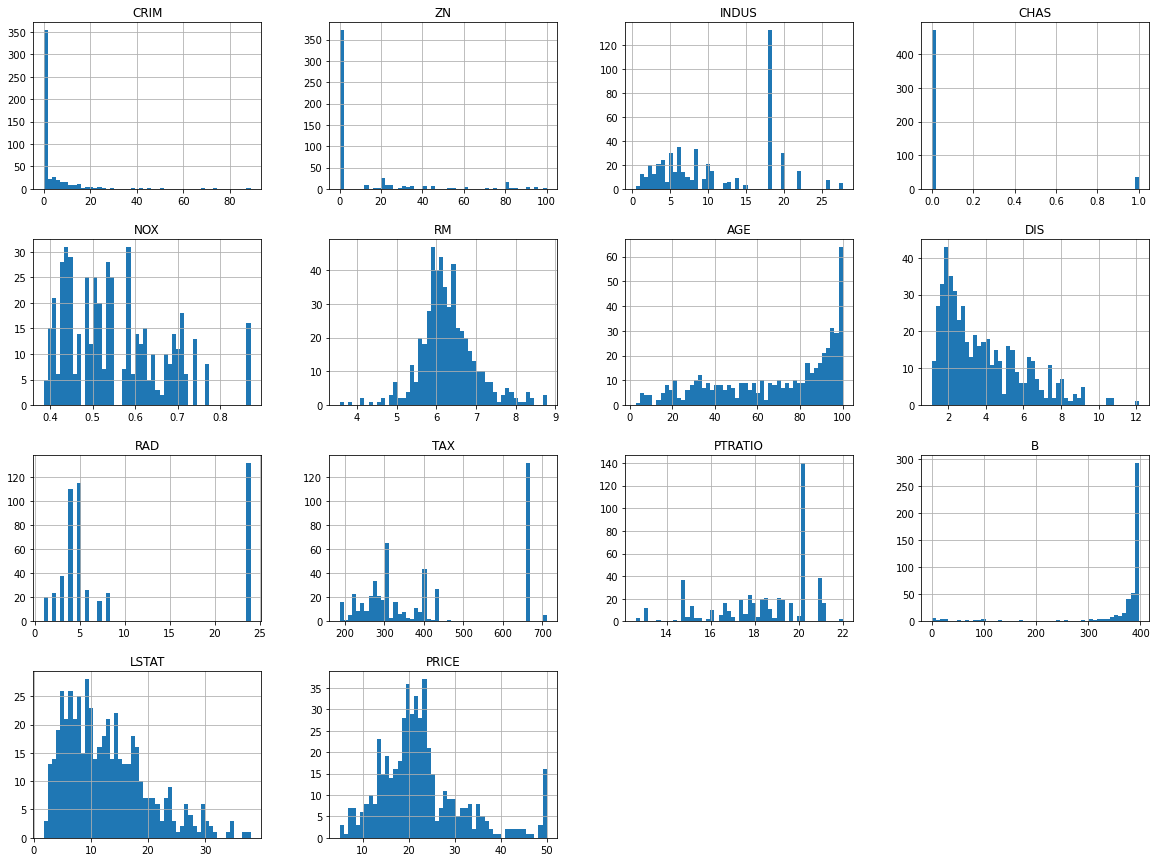

In [6]:
_ = house_dataset.hist(bins=50, figsize=(20,15))

Unfortunately they are quite a lot of outliers and dataset is quite small.

Let's first split set into training and test set (30%, 60%).

In [7]:
train_df, test_df = train_test_split(house_dataset, test_size=0.3) 

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354 entries, 138 to 230
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     354 non-null    float64
 1   ZN       354 non-null    float64
 2   INDUS    354 non-null    float64
 3   CHAS     354 non-null    int64  
 4   NOX      354 non-null    float64
 5   RM       354 non-null    float64
 6   AGE      354 non-null    float64
 7   DIS      354 non-null    float64
 8   RAD      354 non-null    int64  
 9   TAX      354 non-null    float64
 10  PTRATIO  354 non-null    float64
 11  B        354 non-null    float64
 12  LSTAT    354 non-null    float64
 13  PRICE    354 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 41.5 KB


Dataset is small and I'm doing this late at night so let's apply standard scaler to all variables and see what resu;ts we can get.

In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152 entries, 272 to 23
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     152 non-null    float64
 1   ZN       152 non-null    float64
 2   INDUS    152 non-null    float64
 3   CHAS     152 non-null    int64  
 4   NOX      152 non-null    float64
 5   RM       152 non-null    float64
 6   AGE      152 non-null    float64
 7   DIS      152 non-null    float64
 8   RAD      152 non-null    int64  
 9   TAX      152 non-null    float64
 10  PTRATIO  152 non-null    float64
 11  B        152 non-null    float64
 12  LSTAT    152 non-null    float64
 13  PRICE    152 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 17.8 KB


In [10]:
scaler = StandardScaler()
y_scaler = StandardScaler()

train_y = train_df["PRICE"].to_numpy().reshape(-1, 1)
train_df = train_df.drop("PRICE", axis=1)
train_x = scaler.fit_transform(train_df.iloc[:, :])
train_y = y_scaler.fit_transform(train_y)

test_y = test_df["PRICE"].to_numpy().reshape(-1, 1)
test_df = test_df.drop("PRICE", axis=1)
test_x = scaler.transform(test_df.iloc[:, :])

In [11]:
train_x

array([[-0.38926595, -0.52052107,  1.53671422, ...,  1.31094813,
         0.395535  ,  1.18490337],
       [-0.41319792,  3.12547237, -1.44752997, ..., -2.17765211,
         0.43203025, -1.34283596],
       [-0.38094139, -0.52052107, -0.72744397, ..., -0.43335199,
         0.25825831, -1.23287373],
       ...,
       [-0.35967486,  0.2896997 , -1.04924593, ..., -2.45306792,
         0.40350522, -0.44782694],
       [-0.40082269, -0.52052107, -0.09394145, ...,  0.11747962,
         0.44650251, -0.26966029],
       [-0.35999186, -0.52052107, -0.72744397, ..., -0.43335199,
         0.25196602, -0.16108999]])

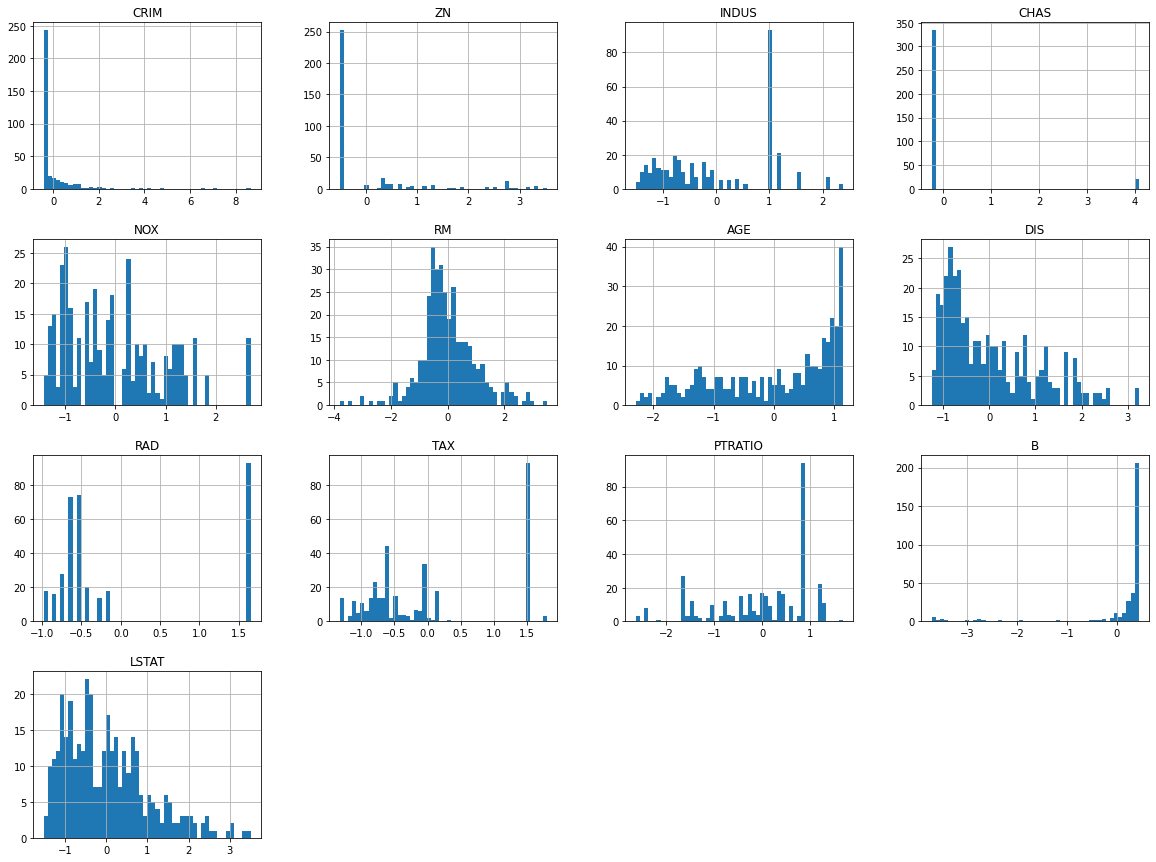

In [12]:
processed_x_train_df = pd.DataFrame(train_x)
processed_x_train_df.columns = header[:-1]
_ = processed_x_train_df.hist(bins=50, figsize=(20,15))

In [13]:
processed_x_train_df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,3.540000e+02,3.540000e+02,3.540000e+02,3.540000e+02,3.540000e+02,3.540000e+02,3.540000e+02,3.540000e+02,3.540000e+02,3.540000e+02,3.540000e+02,3.540000e+02,3.540000e+02
mean,9.534119e-17,1.505387e-17,1.304669e-16,2.007183e-17,-6.397895e-16,-1.558076e-15,2.433709e-16,-2.822601e-16,-2.508979e-17,1.555567e-16,1.756285e-16,-2.107542e-16,-4.177449e-16
std,1.001415e+00,1.001415e+00,1.001415e+00,1.001415e+00,1.001415e+00,1.001415e+00,1.001415e+00,1.001415e+00,1.001415e+00,1.001415e+00,1.001415e+00,1.001415e+00,1.001415e+00
min,-4.140837e-01,-5.205211e-01,-1.515354e+00,-2.447044e-01,-1.432740e+00,-3.814843e+00,-2.292333e+00,-1.243657e+00,-9.817528e-01,-1.326969e+00,-2.636678e+00,-3.712488e+00,-1.515435e+00
25%,-4.065868e-01,-5.205211e-01,-9.013325e-01,-2.447044e-01,-9.039641e-01,-5.540639e-01,-8.956627e-01,-8.038841e-01,-6.383333e-01,-7.534875e-01,-6.628652e-01,2.285535e-01,-8.145997e-01
50%,-3.902572e-01,-5.205211e-01,-1.935125e-01,-2.447044e-01,-1.330980e-01,-1.203676e-01,3.221065e-01,-3.136323e-01,-5.238602e-01,-4.518123e-01,1.863336e-01,3.877221e-01,-1.917124e-01
75%,-2.720630e-02,2.896997e-01,9.897952e-01,-2.447044e-01,5.974198e-01,4.912913e-01,9.128354e-01,6.543512e-01,1.651130e+00,1.528491e+00,8.519218e-01,4.395548e-01,5.985541e-01
max,8.654551e+00,3.530583e+00,2.380903e+00,4.086563e+00,2.695535e+00,3.498439e+00,1.147533e+00,3.241235e+00,1.651130e+00,1.797310e+00,1.678169e+00,4.465025e-01,3.502462e+00


## Models and training

Now let's train models from scikit learn.

In [14]:
svm_model = SVR()
linreg_model = LinearRegression()
svm_model.fit(train_x, np.ravel(train_y))
linreg_model.fit(train_x, np.ravel(train_y))

LinearRegression()

Now let's train neural network model.

In [15]:
class NeuralModel(nn.Module):
    def __init__(self, feature_count):
        super().__init__()
        
        self.fc1 = nn.Linear(feature_count, 150)
        self.fc2 = nn.Linear(150, 150)
        self.output = nn.Linear(150, 1)
        
        self.initialize()
        
    def initialize(self):
        nn.init.kaiming_normal_(self.fc1.weight, mode="fan_in", 
                                 nonlinearity="relu")
        nn.init.kaiming_normal_(self.fc2.weight, mode="fan_in", 
                                 nonlinearity="relu")
        nn.init.xavier_normal_(self.output.weight)
    
    def forward(self, x):
        x = torch_fun.relu(self.fc1(x))
        x = torch_fun.relu(self.fc2(x))
        return self.output(x)

In [16]:
def train_model(model, device, train_dataset, optim, criterion,
          batch_size, epochs, verbose=True):
    
    train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    loss_history = []
    losses = []
    for epoch in range(epochs):
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)

            preds = model(x)
            loss = criterion(preds, y)
            loss.backward()
            optim.step()

            with torch.no_grad():
                losses.append(loss.cpu())
        
        avg_loss = np.average(losses)
        if verbose:
            print(f"Epoch {epoch+1}/{epochs} loss: {avg_loss}")
        
        loss_history.append(avg_loss)
        
    return loss_history

In [17]:
def xy_arrays_to_dataset(x, y):
    x = torch.from_numpy(x).float()
    y = torch.from_numpy(y).float()
    return data.TensorDataset(x, y)

train_dataset = xy_arrays_to_dataset(train_x, train_y)

In [18]:
nn_model = NeuralModel(train_x.shape[1])
_ = summary(nn_model, train_x.shape)

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 354, 150]            2,100
├─Linear: 1-2                            [-1, 354, 150]            22,650
├─Linear: 1-3                            [-1, 354, 1]              151
Total params: 24,901
Trainable params: 24,901
Non-trainable params: 0
Total mult-adds (M): 0.02
Input size (MB): 0.02
Forward/backward pass size (MB): 0.81
Params size (MB): 0.09
Estimated Total Size (MB): 0.93


Function for measuring error will be a MSE.

In [19]:
nn_model.to(device)
optim = torch.optim.SGD(nn_model.parameters(), lr=0.001, weight_decay=0.1, momentum=0.2)
loss = nn.MSELoss()

In [20]:
loss_history = train_model(nn_model, device, train_dataset, optim, loss, train_x.shape[0], 150, verbose=False)

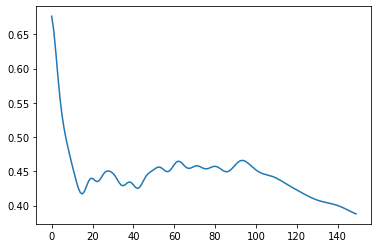

In [21]:
plt.plot(loss_history)

## Model evaluation

Let's now test models on the test dataset and see how well they performed. Each model will be evaluated using mean relative error. We will also determine the histogram of relative errors for each model.

In [22]:
def evaluate_scikit_model(model, test_x, test_y, y_scaler):
    preds = model.predict(test_x)
    preds = y_scaler.inverse_transform(preds)
    preds = test_y.ravel() - preds
    return np.absolute(preds)/test_y.ravel()

def evaluate_nn_model(model, test_x, test_y, y_scaler, device):
    test_x = torch.from_numpy(test_x).float()
    test_dataset = data.TensorDataset(test_x)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256)
    
    preds = np.array([])
    for x in test_loader:
        with torch.no_grad():
            x = x[0].to(device)
            y = model(x)
            y = y.cpu().numpy()
            preds = np.append(preds, y)
    
    preds = y_scaler.inverse_transform(preds)
    preds = test_y.ravel() - preds
    return np.absolute(preds)/test_y.ravel()

In [23]:
svr_errors = evaluate_scikit_model(svm_model, test_x, test_y, y_scaler)
linreg_errors = evaluate_scikit_model(linreg_model, test_x, test_y, y_scaler)

In [24]:
nn_model_random = NeuralModel(train_x.shape[1])
nn_model_random.to(device)

random_nn_errors = evaluate_nn_model(nn_model_random, test_x, test_y, y_scaler, device)
nn_errors = evaluate_nn_model(nn_model, test_x, test_y, y_scaler, device)

In [25]:
np.average(svr_errors)

0.13129643488813136

In [26]:
np.average(linreg_errors)

0.16113033956567396

In [27]:
np.average(random_nn_errors)

0.4969738584270364

In [28]:
np.average(nn_errors)

0.16662949214475176

In [29]:
def plot_hist(data, title):
    plt.title(title)
    plt.hist(data, bins=50)
    plt.xlim(0, 2)
    plt.xlabel("relative error")
    plt.ylabel("count")

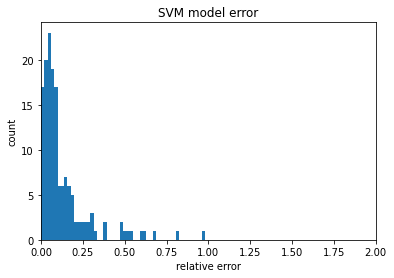

In [31]:
plot_hist(svr_errors, "SVM model error")

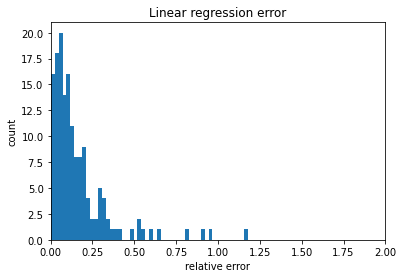

In [33]:
plot_hist(linreg_errors, "Linear regression error")

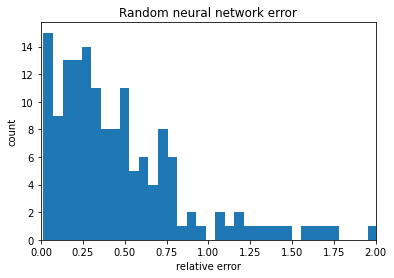

In [34]:
plot_hist(random_nn_errors, "Random neural network error")

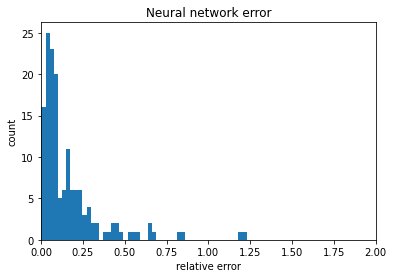

In [35]:
plot_hist(nn_errors, "Neural network error")

As we can see neural network in this case performs similarly to a linear regresssion. The best model in this case seems to be svr with average error of 13% of house value.